# Volume fault extractor

1. Create virtual environment:

`python -m venv ./.venv`

2. Activate environment:

`\.venv\Scripts\Activate.bat`

3. Install python dependencies (assuming CUDA is already installed)

`pip install -r requirements.txt   `


In [4]:
from obspy import read
import torch
import warnings
warnings.simplefilter('always', UserWarning)
warnings.formatwarning = lambda message, category, filename, lineno, line=None: f'{category.__name__}: {message}\n'
import numpy as np
from preprocessing import Seismic
import os
from faultExtractor import FaultExtractor

**Enter path to .sgy file**

In [7]:
#Dixondale volume exported by phil
filePath = "G:/3D Seismic Volumes-SEGY/Seismic Data 3DX/Dixondale/DixondalePSTM_8-14-19_filtered_export3.sgy"

**Import the SEGY file and convert the state plane coords to a 3D numpy array**

In [9]:
#this may take up to 5 minutes depending on file size
stream = read(filePath, format="SEGY")

#makes amplitude values from -1 to 1
stream.normalize()

#create Seismic object from the stream (check preprocessing.py file for documentation)
seismicData = Seismic(stream)

**Plot example cross section to ensure file is valid**

Text(0, 0.5, 'Depth (Samples)')

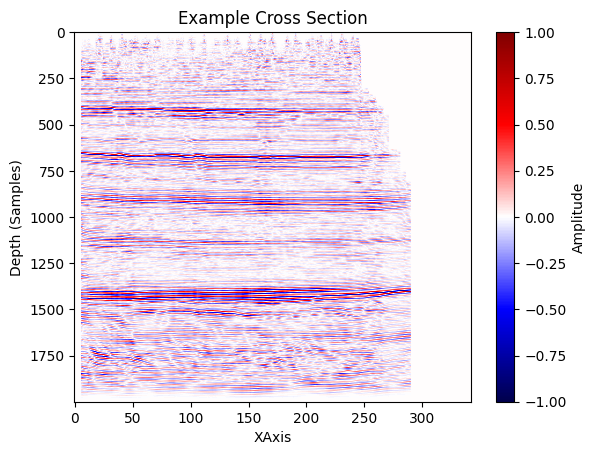

In [4]:
import matplotlib.pyplot as plt


arr = seismicData.seismic_array
crossSection = arr[round(len(arr)/2)]

img = np.flipud(np.rot90(crossSection))

plt.imshow(img, cmap="seismic", aspect="auto")
plt.colorbar(label="Amplitude")
plt.title("Example Cross Section")
plt.xlabel("XAxis")
plt.ylabel("Depth (Samples)")

**Import the fault coordinates and match them with the seismic array (this array will be the same shape as the seismic array)**

*Most indexes in the fault array will be zero. indicies that lie on a fault will be 1. This is the output of the network*

In [5]:
#file location of exported faults.
faults_location = "G:/3D Seismic Volumes-SEGY/Dixondale/Faults Exported/"


#faults_only is the same shape as the seismic array but all values are set to 0, except indexes that lie on a fault, which are set to 1
faults_only = np.zeros(seismicData.seismic_array.shape)

#This could take up to 5 minutes since the files are text based
for i in os.listdir(faults_location):
    faultstr = open(faults_location+i, "r").read()
    faultCoords = seismicData.get_fault_indexes(faultstr)
    for coord in faultCoords:
        try:
            faults_only[coord[0]][coord[1]][coord[2]] = 1
        except:
            warnings.warn(f"Coordinate {coord} is out of bounds for array of size {seismicData.seismic_array.shape}")


**Ensure CUDA is enabled**

In [3]:
if not torch.cuda.is_available():
    warnings.warn("CUDA is not available. this speeds up training in deep neural networks. Visit this link (https://docs.nvidia.com/cuda/) and read one of the installation guides")
else:
    print("Torch with CUDA is enabled")

Torch with CUDA is enabled


**Initialize model with hparams**

In [7]:
import torch.optim as optim
import torch.nn as nn
from hparams import NUM_EPOCHS, BATCH_SIZE

model = FaultExtractor()
#load model onto gpu
model.cuda()

#Mean squared error loss
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


batches = []
blabels = []

i = 0
while i < len(seismicData.seismic_array):
    i += BATCH_SIZE
    batches.append(torch.tensor(seismicData.seismic_array[i-BATCH_SIZE: i], dtype=torch.float).cuda())
    blabels.append(torch.tensor(faults_only[i-BATCH_SIZE: i], dtype=torch.float).cuda())


**Begin Training Process**

In [8]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()


for epoch in range(NUM_EPOCHS):
    for batch, labels in zip(batches, blabels):
        modelinput = torch.reshape(batch, (BATCH_SIZE, 1, batch.shape[1], batch.shape[2]))
        inputlabels = torch.reshape(labels, (BATCH_SIZE, 1, labels.shape[1], labels.shape[2]))
        outputs = model(modelinput)
        loss = criterion(outputs, inputlabels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {loss.item()}')
    writer.add_scalar("Loss/train", loss, epoch)



RuntimeError: shape '[20, 1, 343, 2000]' is invalid for input of size 4116000